In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Check the number of unique classes in your training labels



In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add, BatchNormalization
import tensorflow as tf

# Load TRAIN and TEST data from .xlsx files
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels from train and test data
X_train = trainData.drop(columns=['Genre', 'File Name']).values  # Exclude 'Genre' and 'File Name' columns
y_train = trainData['Genre'].values

X_test = testData.drop(columns=['Genre', 'File Name']).values
y_test = testData['Genre'].values

# Encode labels (Genre) into numerical form
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_onehot = to_categorical(y_train_encoded, num_classes=20)  # Assuming 10 subgenres
y_test_onehot = to_categorical(y_test_encoded, num_classes=20)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be compatible with Conv1D (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)  # Shape (samples, timesteps, 1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

# Define the ResNet block
def resnet_block(input_layer, filters, kernel_size=3, strides=1):
    # First convolutional layer
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)

    # Second convolutional layer
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(conv1)
    conv2 = BatchNormalization()(conv2)

    # Adjust the shortcut (input) to match the number of filters in the conv2 output using 1x1 convolution
    shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same', activation=None)(input_layer)
    shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the output of the second convolutional layer
    output_layer = Add()([shortcut, conv2])

    # Apply ReLU activation
    return tf.keras.activations.relu(output_layer)


# Input Layer (68 features, reshaped to be compatible with Conv1D)
input_layer = Input(shape=(68, 1))  # Input with 68 features

# Layer 1: Conv1D -> ResNet Block -> MaxPooling
x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 2: ResNet Block -> MaxPooling
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 3: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 4: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 5: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 6: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 7: Conv1D -> MaxPooling
x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Global Average Pooling and Output Layer
x = GlobalAveragePooling1D()(x)
output_layer = Dense(10, activation='softmax')(x)  # Assuming 10 classes for subgenres

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_onehot, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_onehot))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30


ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node functional_1/max_pooling1d_5_1/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 3, 1], padding="VALID", strides=[1, 1, 3, 1]](functional_1/max_pooling1d_5_1/MaxPool1d/ExpandDims)' with input shapes: [?,1,2,256].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(None, 2, 256), dtype=float32)

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.0779 - loss: 5.3047 - val_accuracy: 0.1000 - val_loss: 4.8322 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1691 - loss: 4.7467 - val_accuracy: 0.0156 - val_loss: 5.2066 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1899 - loss: 4.6267 - val_accuracy: 0.0469 - val_loss: 5.5883 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2563 - loss: 4.2740 - val_accuracy: 0.0437 - val_loss: 5.4723 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2531 - loss: 4.2189 - val_accuracy: 0.0312 - val_loss: 5.7202 - learning_rate: 0.0010
Epoch 6/100
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3226 - loss: 3.9546
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3208 - loss: 3.9604 - val_accuracy:

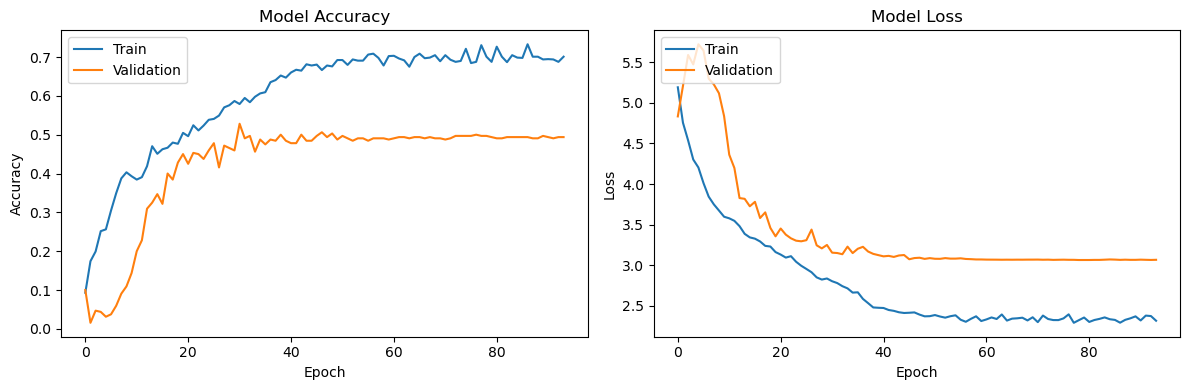

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.0430 - loss: 7.6167 - val_accuracy: 0.0625 - val_loss: 6.5795 - learning_rate: 5.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0687 - loss: 6.7358 - val_accuracy: 0.0531 - val_loss: 6.0223 - learning_rate: 5.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0482 - loss: 6.0588 - val_accuracy: 0.0344 - val_loss: 5.5609 - learning_rate: 5.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.0436 - loss: 5.5656 - val_accuracy: 0.0375 - val_loss: 5.1569 - learning_rate: 5.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0415 - loss: 5.1474 - val_accuracy: 0.0500 - val_loss: 4.7811 - learning_rate: 5.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0547 - loss: 4.7952 - val_accuracy: 0.0406 - val_loss: 4.5052 - learning_rate: 5.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy:

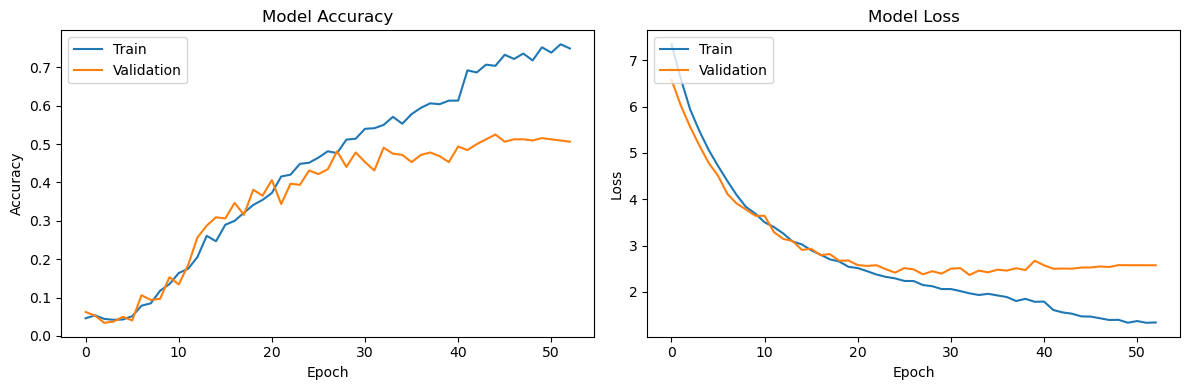

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate, 
    GlobalMaxPooling1D, Multiply, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Feature preprocessing
def preprocess_features(X):
    # Apply RobustScaler for better handling of outliers
    robust_scaler = RobustScaler()
    X_robust = robust_scaler.fit_transform(X)
    
    # Apply StandardScaler after RobustScaler
    standard_scaler = StandardScaler()
    X_scaled = standard_scaler.fit_transform(X_robust)
    
    return X_scaled

X_processed = preprocess_features(X)
X_scaled = np.expand_dims(X_processed, axis=-1)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def squeeze_excitation_block(input_tensor, ratio=16):
    """Squeeze and Excitation block for attention mechanism"""
    filters = input_tensor.shape[-1]

    # Squeeze operation
    x = GlobalAveragePooling1D()(input_tensor)

    # Excitation operation
    x = Dense(filters // ratio, activation='relu')(x)
    x = Dense(filters, activation='sigmoid')(x)

    # Reshape and multiply
    x = tf.keras.layers.Reshape((1, filters))(x)  # Use Keras Reshape layer
    return Multiply()([input_tensor, x])


def advanced_inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = LayerNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = LayerNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = LayerNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # 7x7 convolution
    conv7 = Conv1D(filters, 7, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv7 = LayerNormalization()(conv7)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5, conv7], axis=-1)
    
    # Apply SE block
    se_out = squeeze_excitation_block(concat)
    
    return se_out

def advanced_resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = LayerNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = LayerNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = LayerNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    x = LeakyReLU(alpha=0.2)(x)
    
    # Apply SE block
    x = squeeze_excitation_block(x)
    
    return x

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Advanced Inception Module
x = advanced_inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Second Block: Advanced ResNet
x = advanced_resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Third Block: Advanced Inception Module
x = advanced_inception_module(x, 256)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

# Fourth Block: Advanced ResNet
x = advanced_resnet_block(x, 512)
x = Dropout(0.4)(x)

# Global Pooling with concatenation
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

# Dense Layers with higher capacity
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = LayerNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = LayerNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with optimized learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Calculate balanced class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train with increased epochs and balanced class weights
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,  # Reduced batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()